In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import nn

from src.DRL.qnetwork import QNetwork
from src.Qrunner.qrunner import QrunnerEnv
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['random continuous']
sample_concept.prepare_data(env_steps)
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs

In [4]:
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)
layer = 4
print(f"Using model: {model_path} at layer: {layer}")

test_q_values, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
test_acts = test_acts_dict[layer].cpu().detach().numpy()
test_acts = test_acts.reshape(test_acts.shape[0], -1)

Using model: runs/20240128-235322/model_10000000.pt at layer: 4


In [5]:
concept_cavs = {}
for concept in concept_instances.values():
    probe, score = concept.load_torch_probe()
    if score > 0.85:
        cav = probe[1].weight.data.cpu().numpy().squeeze()
        concept_cavs[concept.name] = cav
        print(f"{concept.name:^35} | {score:^10.4f}")

            player low              |   0.9890  
           player in air            |   0.9780  
       player dodging in air        |   0.9620  
      player standing on wall       |   0.9690  
           visible wall             |   0.9210  
          visible bullet            |   0.8890  
           visible lava             |   0.9570  
          player dodging            |   0.9510  
         lava below player          |   0.9320  
        bullet below player         |   0.9050  


In [6]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def action_name(action_idx):
    return QrunnerEnv.get_action_meanings()[action_idx]

def find_elbow_point(difference):
    # Sort the list based on absolute values in descending order
    sorted_diff = sorted(difference, key=abs, reverse=True)
    
    # Calculate the rate of change in absolute values
    rate_of_change = [abs(sorted_diff[i] - sorted_diff[i+1]) for i in range(len(sorted_diff)-1)]
    elbow_index = 0
    for i in range(1, min(5, len(rate_of_change))):
        if rate_of_change[i] > rate_of_change[elbow_index] * 0.9:
            elbow_index = i
        else:
            break
    return max(1, min(elbow_index + 1, 5))

In [11]:
example_idx = random.randint(0, len(test_images))
example_image = test_images[example_idx]
example_obs = test_obs[example_idx]
example_q_values = test_q_values[example_idx].cpu().detach().numpy()
example_activations = test_acts[example_idx]

original_q_values, acts_dict = model(torch.Tensor(example_obs).unsqueeze(0), return_acts=True)
probabilities = nn.Softmax(dim=1)(original_q_values)
_, original_action = probabilities.max(1)
original_prob = probabilities[0][original_action.item()]
print(f"Original action: {action_name(original_action.item())} | Probability: {original_prob.item():.3f}")
print("-" * 50)
original_acts = acts_dict[layer]

acts_pert = original_acts.clone()
acts_pert.requires_grad = True

optimizer = torch.optim.Adam([acts_pert], lr=0.001)
num_iterations = 1000
lambda_factor = 100

for i in range(num_iterations):
    optimizer.zero_grad()

    q_values = model.network[layer + 1:](acts_pert)
    perturbed_probabilities = nn.Softmax(dim=1)(q_values)
    _, max_perturbed_action = perturbed_probabilities.max(1)
    perturbed_prob = perturbed_probabilities[0][original_action.item()]

    # Loss to decrease the probability of the original action below the threshold
    prob_loss = lambda_factor * perturbed_prob ** 2
    distance_loss = torch.norm(acts_pert - original_acts, p=2)

    if i % 100 == 0:
        print(f"Iteration {i} | Probability: {perturbed_prob.item():.3f} | Distance loss: {distance_loss.item():.3f}")
    
    loss = prob_loss + distance_loss
    loss.backward()
    optimizer.step()

    # Break if the most probable action is not the original action
    if max_perturbed_action.item() != original_action.item():
        print("-" * 50)
        break

_, new_max_action = perturbed_probabilities.max(1)
print(f"{action_name(original_action.item())} probability {perturbed_probabilities[0][original_action.item()].item():.3f}")
print(f"{action_name(new_max_action.item())} probability {perturbed_probabilities[0][new_max_action.item()].item():.3f}")
#print(f"Original Q-values: {original_q_values.data}")
#print(f"New Q-values: {q_values.data}")

acts_pert = acts_pert.detach()
acts_pert = acts_pert.squeeze(0).cpu().numpy().flatten()

Original action: RIGHT | Probability: 0.213
--------------------------------------------------
Iteration 0 | Probability: 0.213 | Distance loss: 0.000
--------------------------------------------------
RIGHT probability 0.206
JUMP probability 0.206


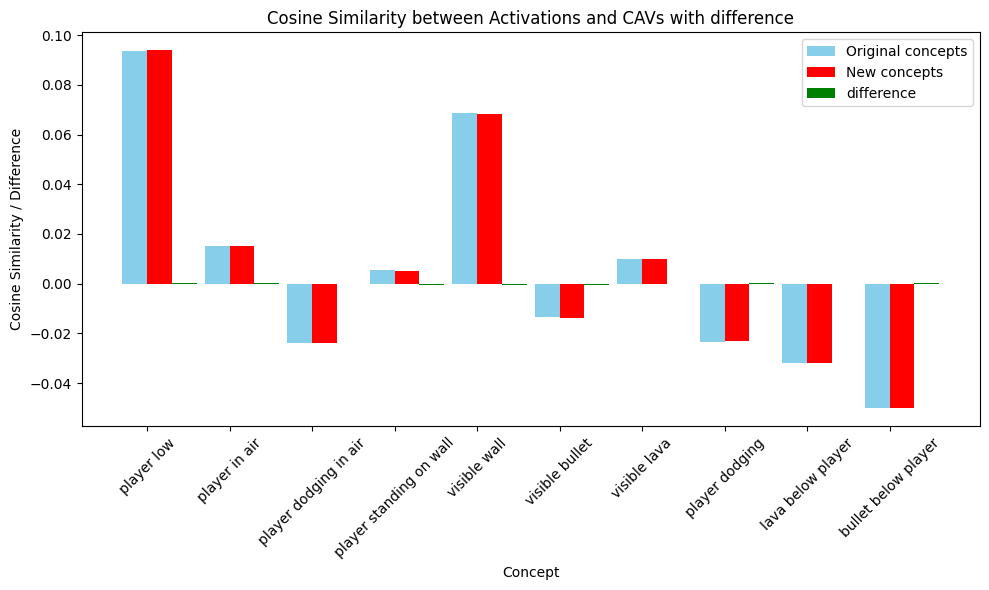

In [12]:
similarity_scores_example = []
similarity_scores_pert = []
difference = []
for concept, cav in concept_cavs.items():
    similarity_scores_example.append(cosine_similarity(example_activations, cav))
    similarity_scores_pert.append(cosine_similarity(acts_pert, cav))
    difference.append(similarity_scores_pert[-1] - similarity_scores_example[-1])

plt.figure(figsize=(10, 6))
concepts = list(concept_cavs.keys())
x = np.arange(len(concepts))
width = 0.3

plt.bar(x - width/2, similarity_scores_example, width, label='Original concepts', color='skyblue')
plt.bar(x + width/2, similarity_scores_pert, width, label='New concepts', color='red')
plt.bar(x + width*1.5, difference, width, label='difference', color='green')

plt.xlabel('Concept')
plt.ylabel('Cosine Similarity / Difference')
plt.title('Cosine Similarity between Activations and CAVs with difference')
plt.xticks(x, concepts, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

If there was less (visible bullet), then the agent would do 'JUMP' instead of 'RIGHT'


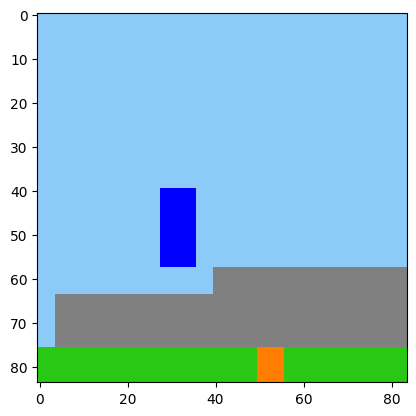

In [14]:
n = find_elbow_point(difference)

# Sort the list based on absolute values in descending order and pick top n
sorted_concepts = sorted(zip(concepts, difference), key=lambda x: abs(x[1]), reverse=True)
relevant_concepts = sorted_concepts[:n]

positive_relevant_concepts = [concept for concept, diff in relevant_concepts if diff > 0]
negative_relevant_concepts = [concept for concept, diff in relevant_concepts if diff < 0]

# Constructing the conditional sentence parts based on the list contents
positive_part = f"more ({', '.join(positive_relevant_concepts)})" if positive_relevant_concepts else ""
negative_part = f"less ({', '.join(negative_relevant_concepts)})" if negative_relevant_concepts else ""

# Combining the parts with proper language structure
condition_parts = []
if positive_part:
    condition_parts.append(positive_part)
if negative_part:
    condition_parts.append(negative_part)

condition_sentence = ", and ".join(condition_parts)

# Using the constructed sentence in the print statement
if condition_sentence:  # Checks if there's any condition to mention
    print(f"If there was {condition_sentence}, then the agent would do '{action_name(new_max_action.item())}' instead of '{action_name(original_action.item())}'")
else:
    print(f"The agent would do '{action_name(new_max_action.item())}' instead of '{action_name(original_action.item())}'")
    
plt.imshow(example_image)
plt.show()